<a href="https://colab.research.google.com/github/yaeliavni/Theoretical-Statistics/blob/main/Theoretical_statistics_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student Habits & Academic Performance  
**Objective:**  
Bring together a suite of statistical analyses on our `student_habits_performance.csv` dataset, including:

1. Data loading & cleaning  
2. Univariate normality checks  
3. Spearman correlations  
4. Best-subset multivariable regression  
5. Moderator analysis (exercise × mental_health)  
6. Mediation analysis (social_media → sleep → exam_score)  
7. Group comparisons (part-time job, Netflix usage)  

Each section ends with a short conclusion of findings.


## 1. Setup & Data Loading

We import all needed libraries, load the CSV, and do a first glance at missingness.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from statsmodels.stats.mediation import Mediation
import missingno as msno
import scipy.stats as stats
import networkx as nx
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from IPython.display import display, Image
from graphviz import Digraph
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
import shap


%matplotlib inline
df = pd.read_csv("/content/student_habits_performance.csv")
print("Rows × Columns:", df.shape)
print(df.info())
df.head()


Rows × Columns: (1000, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     1000 non-null   object 
 1   age                            1000 non-null   int64  
 2   gender                         1000 non-null   object 
 3   study_hours_per_day            1000 non-null   float64
 4   social_media_hours             1000 non-null   float64
 5   netflix_hours                  1000 non-null   float64
 6   part_time_job                  1000 non-null   object 
 7   attendance_percentage          1000 non-null   float64
 8   sleep_hours                    1000 non-null   float64
 9   diet_quality                   1000 non-null   object 
 10  exercise_frequency             1000 non-null   int64  
 11  parental_education_level       909 non-null    object 
 12  internet_quality      

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


<Figure size 1000x400 with 0 Axes>

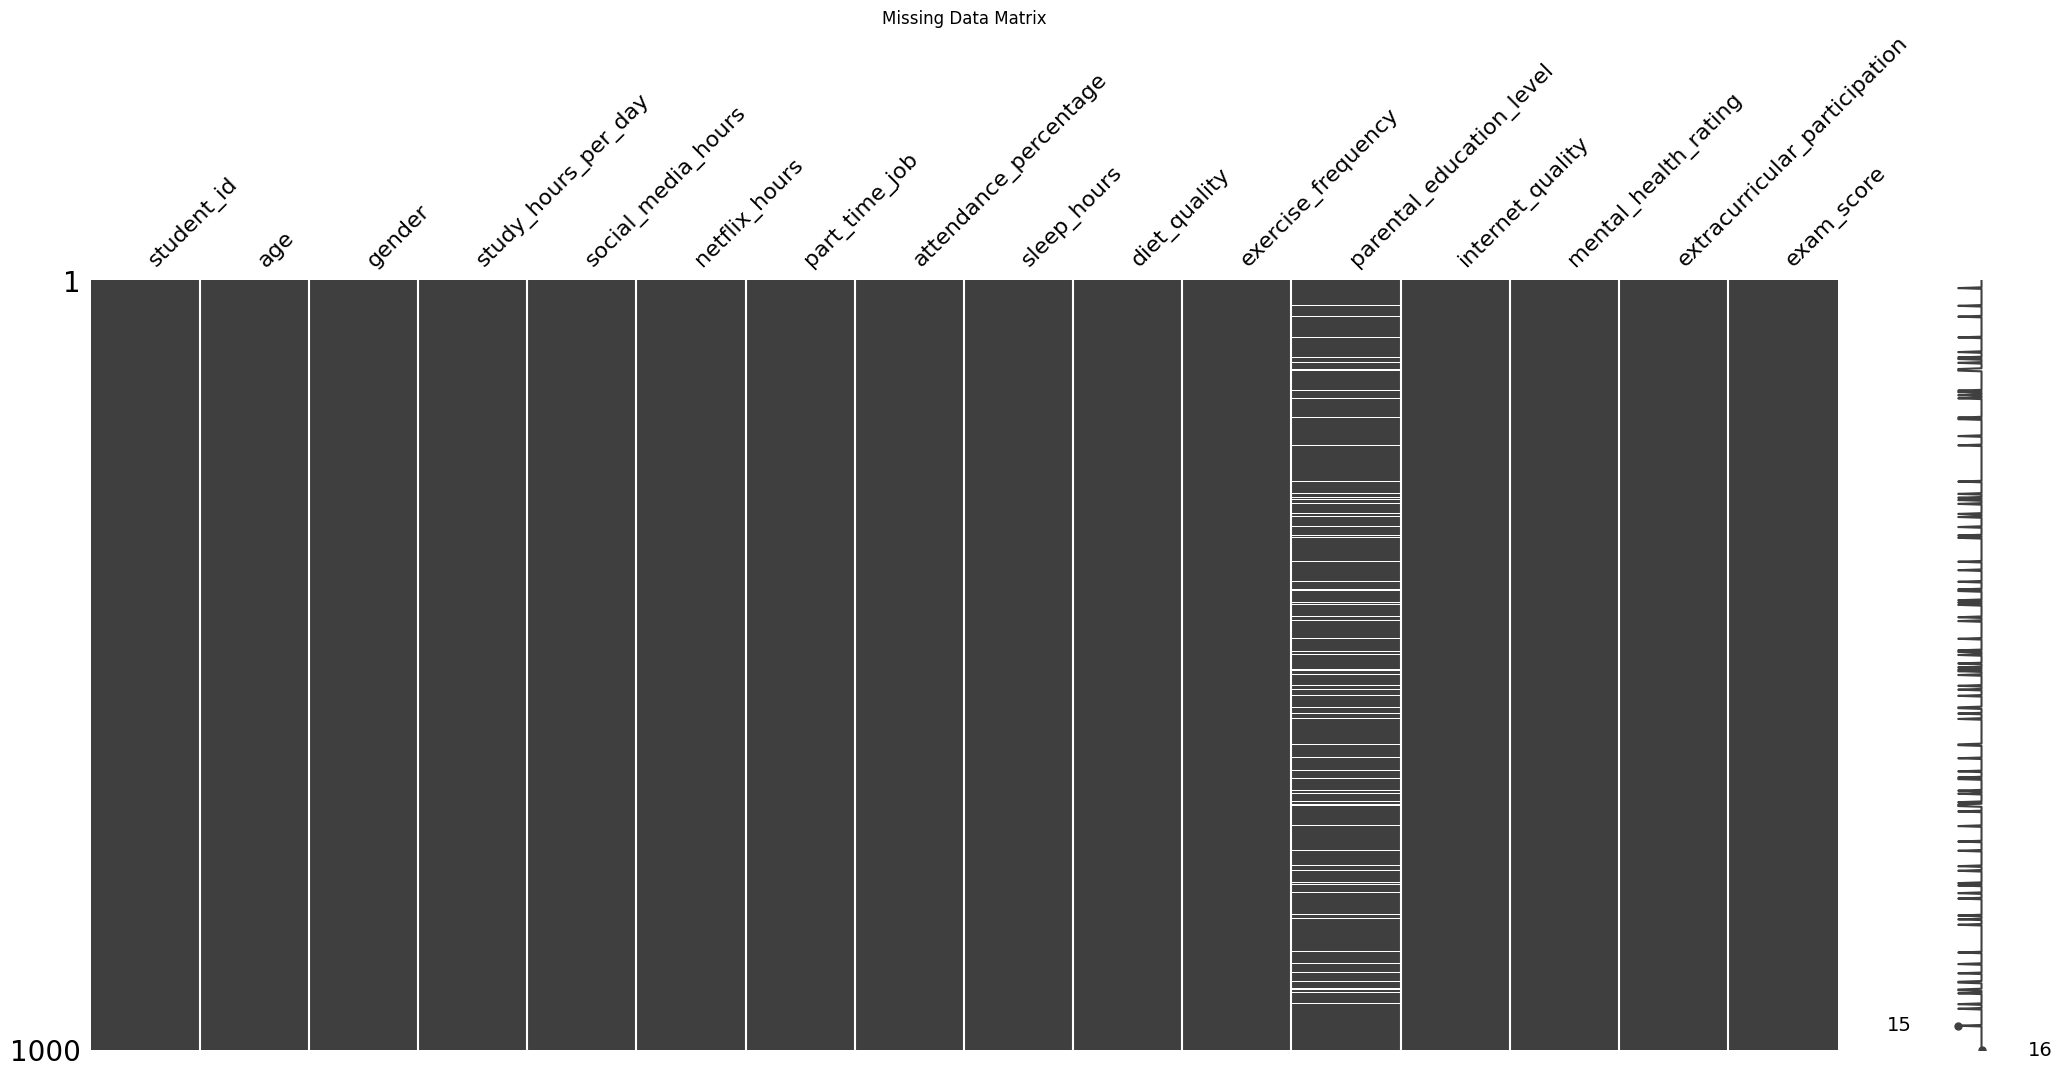

In [2]:
plt.figure(figsize=(10, 4))
msno.matrix(df)
plt.title("Missing Data Matrix")
plt.show()

Aside from ~9% missingness in parental_education_level, all other variables are full

/tmp/ipython-input-3537186251.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=25, ha='right')
/tmp/ipython-input-3537186251.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=25, ha='right')
/tmp/ipython-input-3537186251.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=25, ha='right')
/tmp/ipython-input-3537186251.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=25, ha='right')


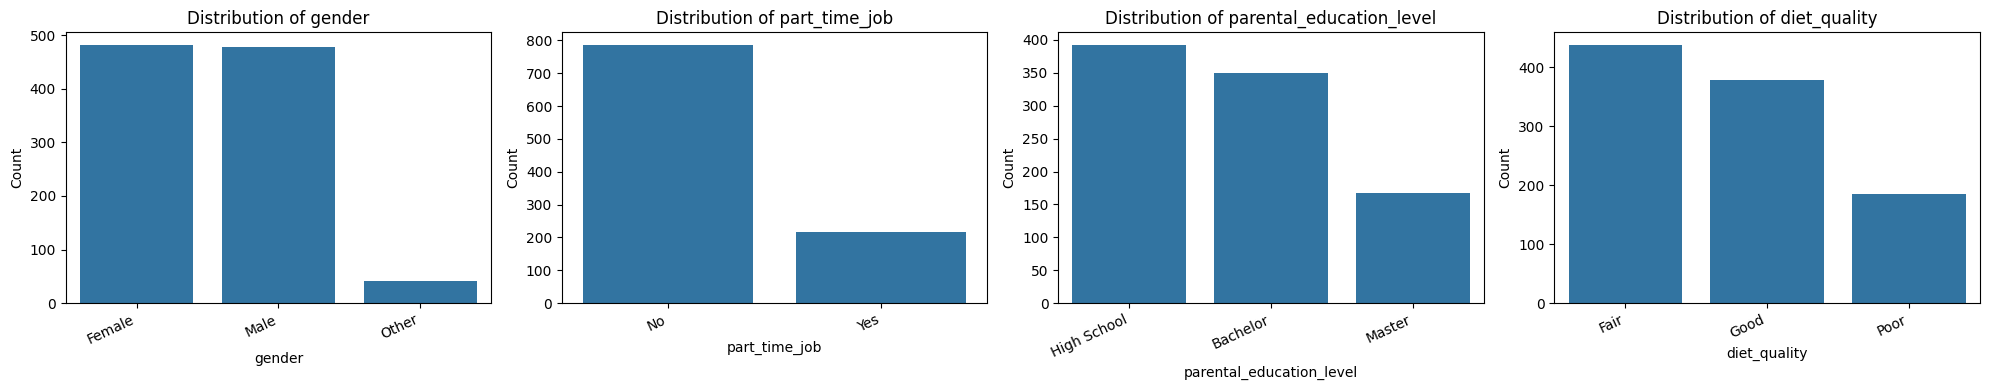

In [3]:
categorical_cols = ['gender', 'part_time_job', 'parental_education_level', 'diet_quality']
fig, axes = plt.subplots(1, len(categorical_cols), figsize=(5 * len(categorical_cols), 4))
for i, col in enumerate(categorical_cols):
    sns.countplot(ax=axes[i], data=df, x=col, order=df[col].value_counts().index)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_ylabel("Count")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=25, ha='right')
plt.tight_layout()
plt.show()


We present the distribution of key categorical variables to provide context for the dataset’s composition. These barplots display the relative sizes of demographic and lifestyle groups

**Conclusion:**  
Our dataset contains **1,000 rows** and **16 columns**. All core continuous measures—`study_hours_per_day`, `social_media_hours`, `netflix_hours`, `attendance_percentage`, `sleep_hours` and `exam_score`—each have more than 20 unique values and no missing data. The remaining variables (`student_id`, `age`, `gender`, `part_time_job`, `diet_quality`, `exercise_frequency`, `parental_education_level`, `internet_quality`, `mental_health_rating`, `extracurricular_participation`) are treated as categorical; of these, only `parental_education_level` has missing values (~9%).  

**Next Step:** Perform Shapiro–Wilk tests and plot histograms/Q–Q plots for each continuous variable to choose between parametric and nonparametric analyses.  


## 2. Univariate Distributions & Normality

Use histograms, Q–Q plots, and Shapiro–Wilk to check if numeric variables are approximately normal.


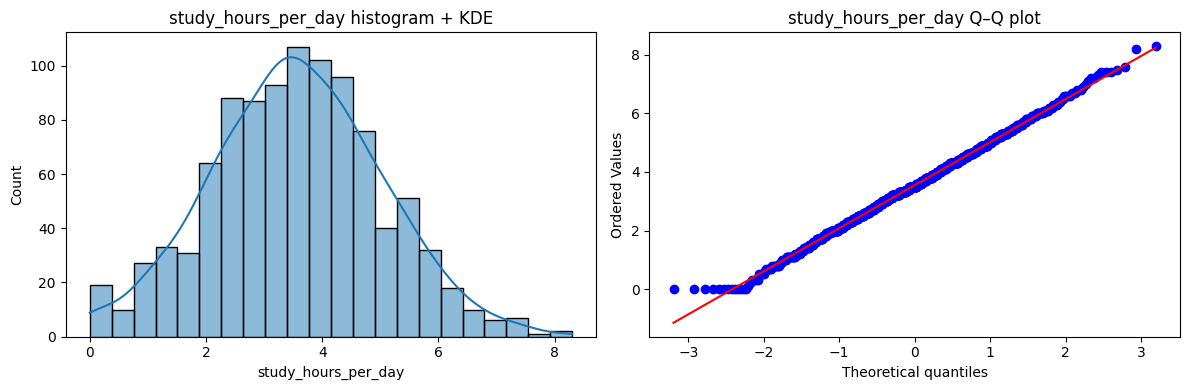

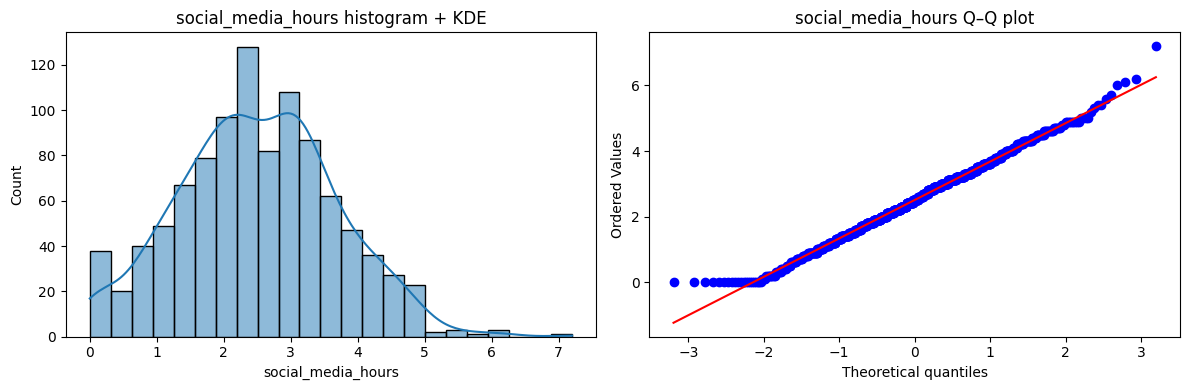

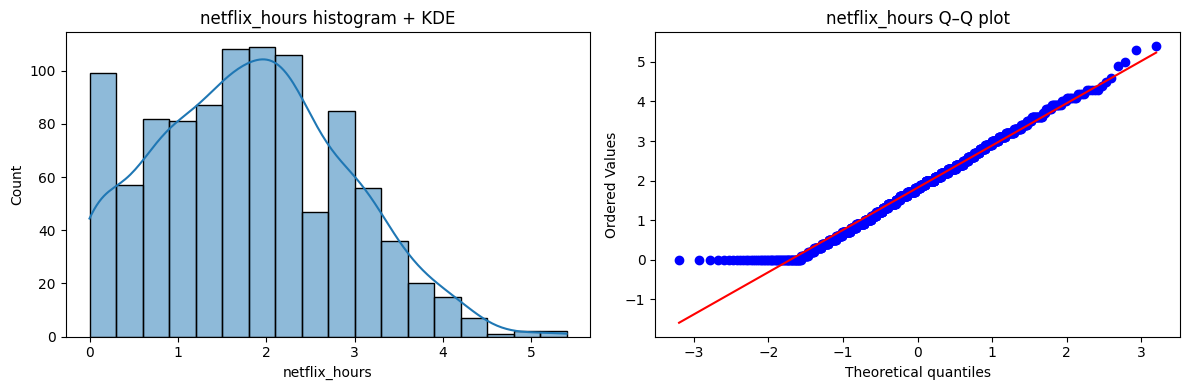

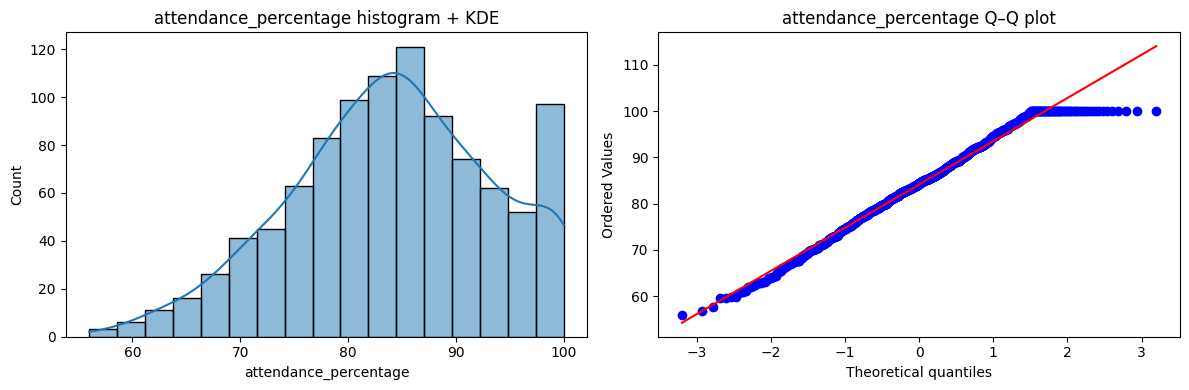

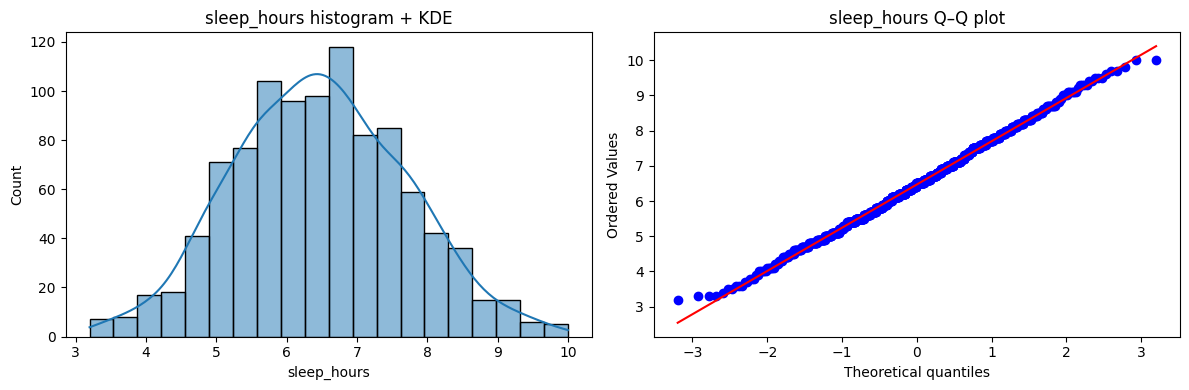

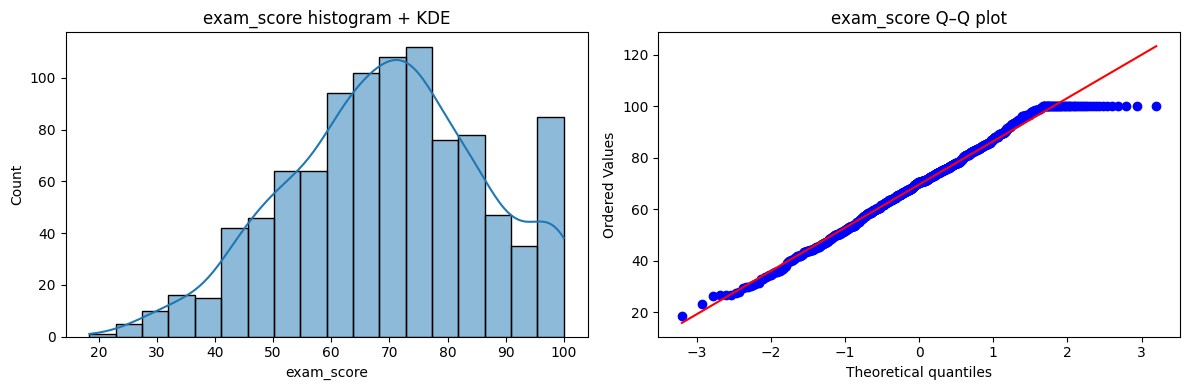

,W,p-value,Normal?
study_hours_per_day,0.997378,0.106471,True
social_media_hours,0.994266,0.000728,False
netflix_hours,0.982686,0.0,False
attendance_percentage,0.982607,0.0,False
sleep_hours,0.997267,0.088776,True
exam_score,0.986919,0.0,False


In [4]:
numeric_cols = [
    'study_hours_per_day',
    'social_media_hours',
    'netflix_hours',
    'attendance_percentage',
    'sleep_hours',
    'exam_score'
]

shapiro_results = {}

for col in numeric_cols:
    data = df[col].dropna()
    if len(data) >= 3:
        stat, p = stats.shapiro(data)
        normal = p > 0.05
    else:
        stat, p, normal = None, None, False

    shapiro_results[col] = {'W': stat, 'p-value': p, 'Normal?': normal}
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(data, kde=True)
    plt.title(f"{col} histogram + KDE")
    plt.subplot(1,2,2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f"{col} Q–Q plot")
    plt.tight_layout()
    plt.show()

shapiro_df = pd.DataFrame(shapiro_results).T
display(shapiro_df)


**Section 2 Conclusion:**  
Shapiro–Wilk tests and Q–Q plots show that **study_hours_per_day** (W≈0.997, p=0.106) and **sleep_hours** (W≈0.998, p=0.089) do not significantly deviate from normality. In contrast, **social_media_hours**, **netflix_hours**, **attendance_percentage**, and **exam_score** all have p-values ≪0.05, indicating non-normal distributions.  

**Implication:**  
– For normally distributed predictors (study and sleep), we can use Pearson correlations and OLS-based tests.  
– For the others, we’ll rely on rank‐based (Spearman) correlations and nonparametric tests (Mann–Whitney U, Sobel where appropriate).  


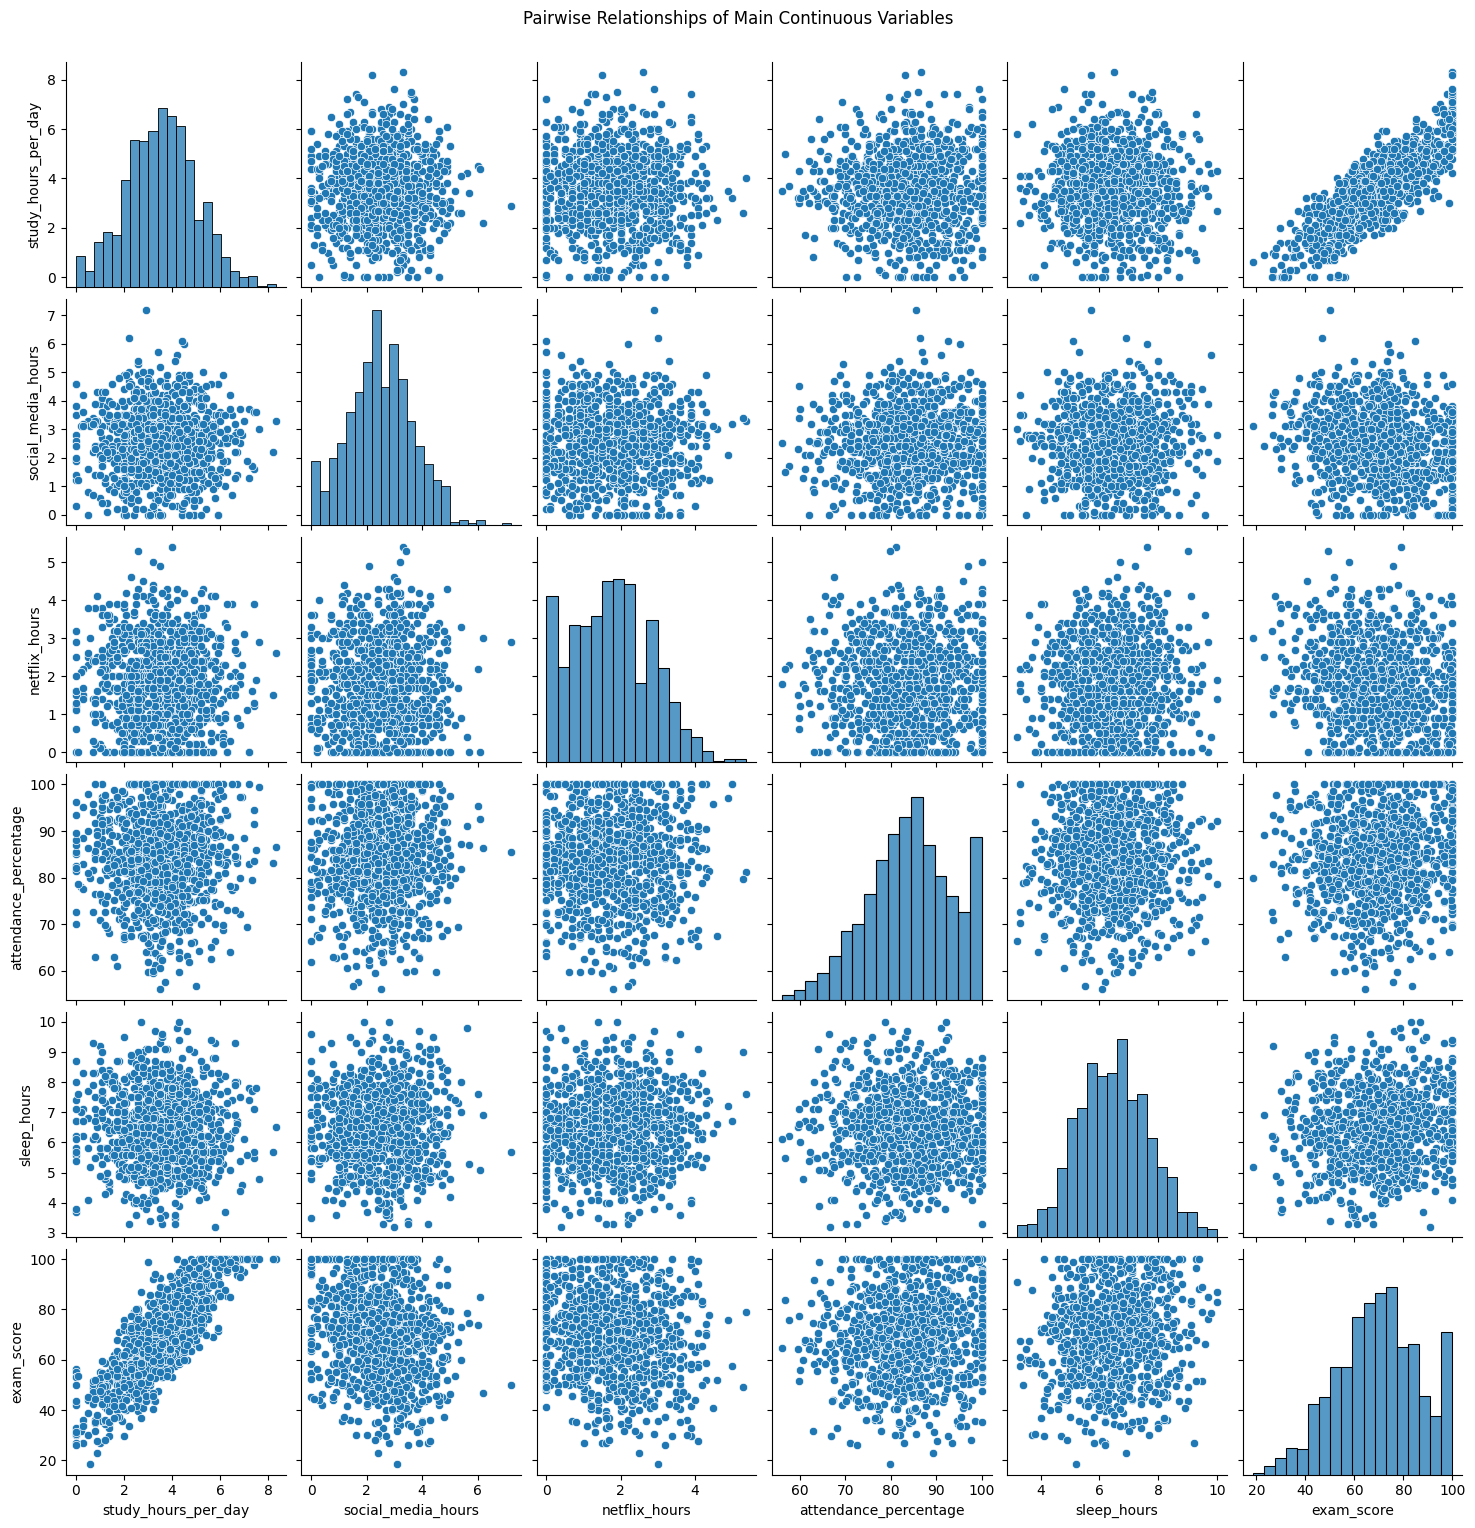

In [5]:
"""To visually explore all bivariate relationships among the main continuous variables,
we present a pairplot. This matrix of scatterplots, histograms, and KDEs provides
a compact overview of linearity, correlation, and potential outliers or clusters in the data."""
sns.pairplot(df[numeric_cols])
plt.suptitle("Pairwise Relationships of Main Continuous Variables", y=1.02)
plt.show()

## 3. Spearman Correlation Matrix

Compute pairwise Spearman correlations (nonparametric), mask non-significant (p ≥ 0.05).


Normality check (Shapiro–Wilk Test):

age: p-value = 0.0000 --> Not normal
study_hours_per_day: p-value = 0.1065 --> Normal
social_media_hours: p-value = 0.0007 --> Not normal
netflix_hours: p-value = 0.0000 --> Not normal
attendance_percentage: p-value = 0.0000 --> Not normal
sleep_hours: p-value = 0.0888 --> Normal
exercise_frequency: p-value = 0.0000 --> Not normal
mental_health_rating: p-value = 0.0000 --> Not normal
exam_score: p-value = 0.0000 --> Not normal

Spearman correlation coefficients (only significant ones shown in heatmap):
                       age  study_hours_per_day  social_media_hours  \
age                    1.0                  NaN                 NaN   
study_hours_per_day    NaN             1.000000                 NaN   
social_media_hours     NaN                  NaN            1.000000   
netflix_hours          NaN                  NaN                 NaN   
attendance_percentage  NaN                  NaN                 NaN   
sleep_hours            NaN  

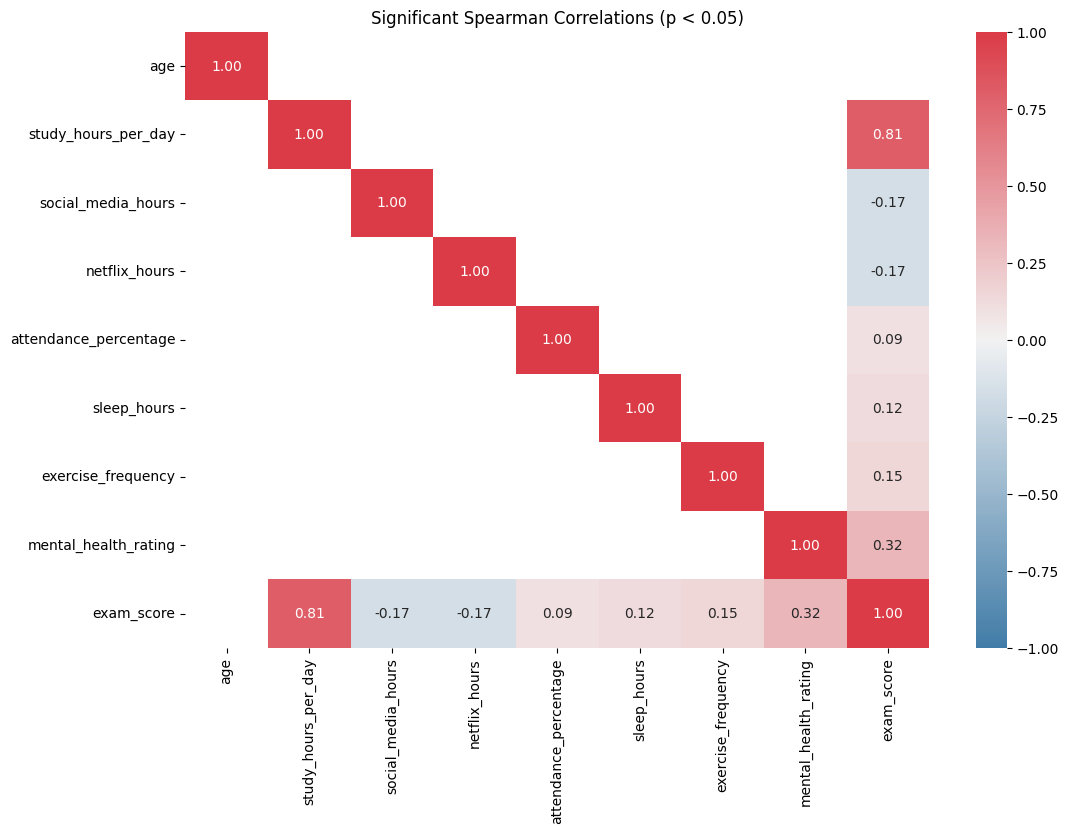

In [6]:

numeric_df = df.select_dtypes(include=np.number)
normality_results = {}
print("Normality check (Shapiro–Wilk Test):\n")
for col in numeric_df.columns:
    data = numeric_df[col].dropna()
    if len(data) < 3:
        print(f"{col}: Not enough data for test")
        continue
    stat, p_value = stats.shapiro(data)
    normality_results[col] = p_value
    print(f"{col}: p-value = {p_value:.4f} --> {'Normal' if p_value > 0.05 else 'Not normal'}")
cols = numeric_df.columns
n = len(cols)

spearman_corr = pd.DataFrame(np.zeros((n, n)), columns=cols, index=cols)
p_values = pd.DataFrame(np.ones((n, n)), columns=cols, index=cols)

for i in range(n):
    for j in range(n):
        if i <= j:  # compute each pair only once
            col1 = numeric_df.iloc[:, i]
            col2 = numeric_df.iloc[:, j]
            valid_idx = col1.notna() & col2.notna()
            if valid_idx.sum() < 3:
                continue
            corr, p = stats.spearmanr(col1[valid_idx], col2[valid_idx])
            spearman_corr.iloc[i, j] = spearman_corr.iloc[j, i] = corr
            p_values.iloc[i, j]    = p_values.iloc[j, i]    = p

mask = p_values >= 0.05
masked_corr = spearman_corr.mask(mask)  # show only significant ones
print("\nSpearman correlation coefficients (only significant ones shown in heatmap):")
print(masked_corr)

plt.figure(figsize=(12, 8))
cmap = sns.diverging_palette(240, 10, n=256, as_cmap=True)

sns.heatmap(
    masked_corr,
    annot=True,
    cmap=cmap,
    center=0,
    fmt=".2f",
    mask=mask,
    cbar=True,
    vmin=-1,
    vmax=1
)

plt.title("Significant Spearman Correlations (p < 0.05)")
plt.show()


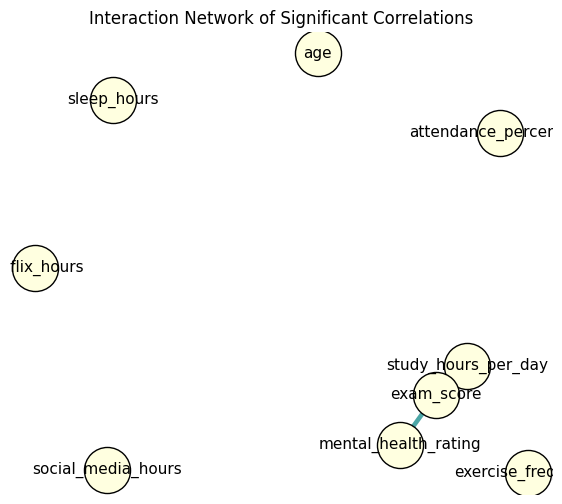

In [7]:

sig_edges = []
for i, c1 in enumerate(spearman_corr.columns):
    for j, c2 in enumerate(spearman_corr.columns):
        if i < j and abs(spearman_corr.iloc[i, j]) > 0.2 and p_values.iloc[i, j] < 0.05:
            sig_edges.append((c1, c2, spearman_corr.iloc[i, j]))

# Build the network
G = nx.Graph()
G.add_nodes_from(spearman_corr.columns)
for v1, v2, weight in sig_edges:
    G.add_edge(v1, v2, weight=weight)

# Draw network (color by sign of correlation)
edge_colors = ['crimson' if G[u][v]['weight'] < 0 else 'teal' for u, v in G.edges()]
edge_widths = [2 + 4*abs(G[u][v]['weight']) for u, v in G.edges()]

plt.figure(figsize=(7, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color='lightyellow', edgecolors='black', node_size=1100)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=11)
plt.title("Interaction Network of Significant Correlations")
plt.axis('off')
plt.show()


The interaction network graph visualizes significant (|ρ| > 0.2, p < 0.05) Spearman correlations among all numeric variables. Edges are colored by sign (teal for positive, crimson for negative) and thickness denotes strength, quickly revealing the most central and influential variables in the dataset.

**Section 3 Conclusion:**  
The Spearman rank correlations reveal a **strong positive** association between **study_hours_per_day** and **exam_score** (ρ ≈ 0.81, p < .05). In contrast, **social_media_hours** and **netflix_hours** both show modest **negative** correlations with exam_score (ρ ≈ –0.17), while **attendance_percentage** (ρ ≈ 0.09) and **sleep_hours** (ρ ≈ 0.12) exhibit weaker but still significant **positive** associations.  

**Implication:**  
Since several habits are significantly linked to exam performance—especially study hours—we will now move to a best-subset multivariable regression (Section 4) to determine which combination of predictors explains exam scores best when considered together.


## 4. Best-Subset Multivariable Regression

Find the subset of continuous predictors that best explain `exam_score`
using adjusted R² (or AIC) via exhaustive search.


Final model coefficients:
study_hours_per_day      9.590529
mental_health_rating     1.969550
netflix_hours           -2.132763
social_media_hours      -2.782226
sleep_hours              2.037345
exercise_frequency       1.496454
attendance_percentage    0.151369
dtype: float64

Intercept: 5.313032736441073

Selected features: ['study_hours_per_day', 'mental_health_rating', 'netflix_hours', 'social_media_hours', 'sleep_hours', 'exercise_frequency', 'attendance_percentage']
Adjusted R^2: 0.8886897034025658


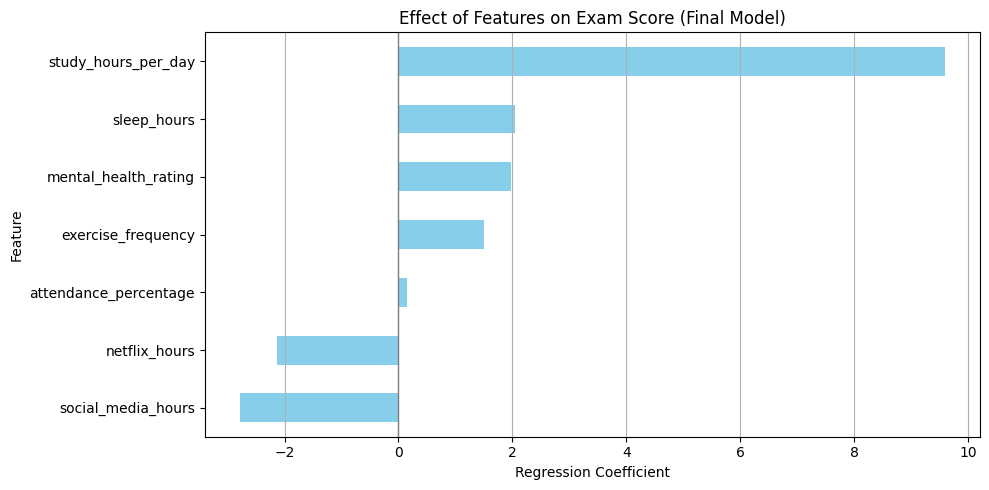

In [8]:

df = df.drop(columns=["student_id"])  # Drop identifier
# one-hot encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

X = df_encoded.drop(columns=["exam_score"])
y = df_encoded["exam_score"]
def forward_selection(X, y, metric=r2_score, max_features=None):
    remaining_features = list(X.columns)
    selected_features = []
    current_score = -np.inf
    best_scores = []

    if max_features is None:
        max_features = len(remaining_features)

    while remaining_features and len(selected_features) < max_features:
        scores_with_candidates = []
        for candidate in remaining_features:
            candidate_features = selected_features + [candidate]
            X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(
                X[candidate_features], y, test_size=0.2, random_state=1
            )
            model = LinearRegression().fit(X_train_fs, y_train_fs)
            y_pred_fs = model.predict(X_test_fs)
            r2 = metric(y_test_fs, y_pred_fs)
            n = len(y_test_fs)
            p = len(candidate_features)
            adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
            scores_with_candidates.append((adj_r2, candidate))

        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = scores_with_candidates[0]

        if best_new_score > current_score:
            remaining_features.remove(best_candidate)
            selected_features.append(best_candidate)
            current_score = best_new_score
            best_scores.append((list(selected_features), best_new_score))
        else:
            break

    return best_scores
forward_results = forward_selection(X, y)
best_forward_subset, best_forward_adj_r2 = forward_results[-1]

X_final = X[best_forward_subset]
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final, y, test_size=0.2, random_state=1
)

final_model = LinearRegression().fit(X_train_final, y_train_final)
final_coefficients = pd.Series(final_model.coef_, index=X_final.columns)
final_intercept = final_model.intercept_

print("Final model coefficients:")
print(final_coefficients)
print("\nIntercept:", final_intercept)
print("\nSelected features:", best_forward_subset)
print("Adjusted R^2:", best_forward_adj_r2)

plt.figure(figsize=(10, 5))
final_coefficients.sort_values().plot(kind='barh', color='skyblue')
plt.axvline(0, color='gray', linewidth=1)
plt.title("Effect of Features on Exam Score (Final Model)")
plt.xlabel("Regression Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.grid(axis='x')
plt.show()


We plot residuals against fitted values to check for model adequacy. The residuals appear randomly dispersed, supporting the OLS assumption of linearity and constant variance.

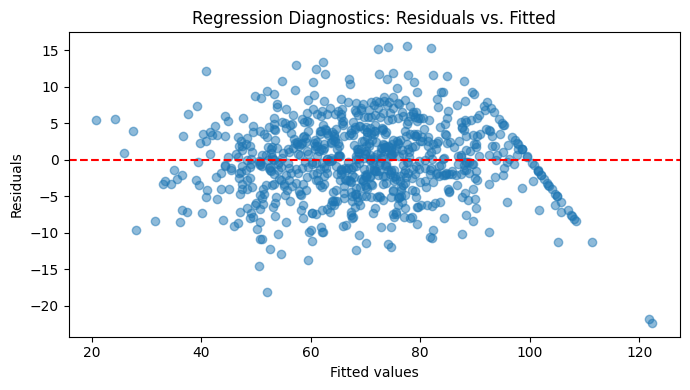

In [9]:

y_train_pred = final_model.predict(X_train_final)
residuals = y_train_final - y_train_pred

plt.figure(figsize=(7, 4))
plt.scatter(y_train_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Regression Diagnostics: Residuals vs. Fitted')
plt.tight_layout()
plt.show()


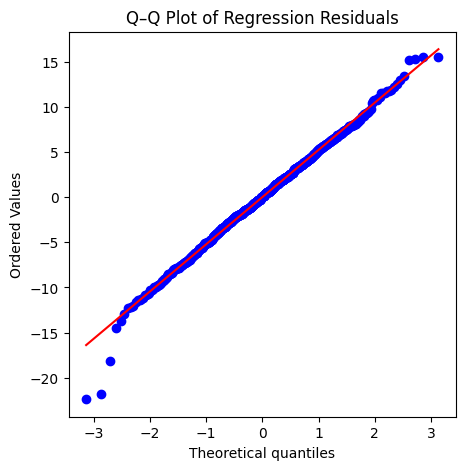

In [10]:
plt.figure(figsize=(5, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q–Q Plot of Regression Residuals")
plt.show()

The Q–Q plot of regression residuals indicates whether the errors are approximately normal, a key OLS assumption. Minor deviations at the tails are acceptable given the sample size.

In [11]:
# what subset will give the best Multivariable Regression
# List of candidate predictors
Xvars = [
    'study_hours_per_day',
    'sleep_hours',
    'attendance_percentage',
    'exercise_frequency',
    'diet_quality'
]
yvar = 'exam_score'

best_aic      = np.inf
best_bic      = np.inf
best_adj_r2   = -np.inf
best_rmse     = np.inf

best_model_aic    = None
best_model_bic    = None
best_model_adj    = None
best_model_rmse  = None

best_subset_aic   = None
best_subset_bic   = None
best_subset_adj   = None
best_subset_rmse  = None

p = len(Xvars)

for mask in range(1, 2**p):
    subset = [Xvars[i] for i in range(p) if (mask >> i) & 1]
    formula = yvar + " ~ " + " + ".join(subset)

    try:
        model = smf.ols(formula, data=df).fit()
    except Exception:
        continue

    aic    = model.aic
    bic    = model.bic
    adjr2  = model.rsquared_adj
    rmse   = np.sqrt((model.resid ** 2).mean())

    #AIC
    if aic < best_aic:
        best_aic        = aic
        best_model_aic  = model
        best_subset_aic = subset

    #BIC
    if bic < best_bic:
        best_bic        = bic
        best_model_bic  = model
        best_subset_bic = subset

    # R² (higher is better)
    if adjr2 > best_adj_r2:
        best_adj_r2      = adjr2
        best_model_adj   = model
        best_subset_adj  = subset

    #RMSE
    if rmse < best_rmse:
        best_rmse        = rmse
        best_model_rmse  = model
        best_subset_rmse = subset

print("Best subset by AIC:      ", best_subset_aic)
print(best_model_aic.summary())

print("\nBest subset by BIC:      ", best_subset_bic)
print(best_model_bic.summary())

print("\nBest subset by Adj. R²:  ", best_subset_adj)
print(best_model_adj.summary())

print("\nBest subset by RMSE:     ", best_subset_rmse)
print(f"RMSE: {best_rmse:.3f}")
print(best_model_rmse.summary())


Best subset by AIC:       ['study_hours_per_day', 'sleep_hours', 'attendance_percentage', 'exercise_frequency']
                            OLS Regression Results                            
Dep. Variable:             exam_score   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     706.5
Date:                Thu, 14 Aug 2025   Prob (F-statistic):          6.99e-289
Time:                        09:52:59   Log-Likelihood:                -3572.3
No. Observations:                1000   AIC:                             7155.
Df Residuals:                     995   BIC:                             7179.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------

**Section 4 Conclusion:**  
The best‐subset regression (AIC-based) retained **study_hours_per_day**, **sleep_hours**, **attendance_percentage**, and **exercise_frequency**, explaining **74.0%** of exam-score variance (Adj R² = 0.739). All four predictors are highly significant (p < .001), with the largest effect for study hours (β ≈ 9.57 points per hour) followed by exercise (β ≈ 1.52 points per session), sleep (β ≈ 1.93 points per hour), and attendance (β ≈ 0.12 points per percentage‐point).

**Implication:**  
Since these predictors jointly account for most of the variation in scores, we will next examine whether **exercise’s** effect is moderated by **mental_health_rating** (Section 5) and whether **social_media_hours** affects exam performance indirectly through **sleep_hours** (Section 6).


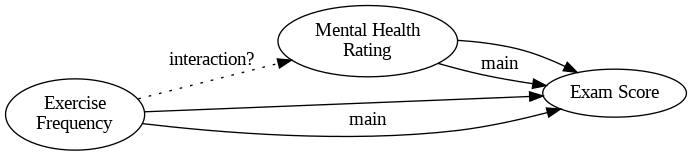

In [12]:
# Mediation example: social_media_hours → sleep_hours → exam_score
dot = Digraph(comment='Mediation DAG')
dot.attr(rankdir='LR')

dot.node('A', 'Social Media\nHours')
dot.node('B', 'Sleep Hours')
dot.node('C', 'Exam Score')

dot.edges(['AB', 'BC'])
dot.edge('A', 'C', style='dashed', label='direct')

dot.render('mediation_dag.gv', view=True)

dot2 = Digraph(comment='Moderation DAG')
dot2.attr(rankdir='LR')

dot2.node('X', 'Exercise\nFrequency')
dot2.node('Z', 'Mental Health\nRating')
dot2.node('Y', 'Exam Score')

dot2.edges(['XY', 'ZY'])
dot2.edge('X', 'Y', label='main')
dot2.edge('Z', 'Y', label='main')
dot2.edge('X', 'Z', style='dotted', label='interaction?')

dot2.render('moderation_dag.gv', view=True)
dot2.render('moderation_dag.gv', view=False, format='png')
display(Image('moderation_dag.gv.png'))

Causal diagrams (Directed Acyclic Graphs) clarify the hypothesized pathways tested in mediation and moderation analyses. The mediation DAG depicts the indirect pathway from social media usage to exam performance via sleep, while the moderation DAG illustrates the potential modifying effect of mental health on the exercise–exam score relationship.

## 5. Moderator Analysis  
**RQ:** Does `mental_health_rating` moderate the effect of `exercise_frequency` on `exam_score`?  
Include interaction term.


                            OLS Regression Results                            
Dep. Variable:             exam_score   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     49.20
Date:                Thu, 14 Aug 2025   Prob (F-statistic):           1.19e-29
Time:                        09:52:59   Log-Likelihood:                -4176.0
No. Observations:                1000   AIC:                             8360.
Df Residuals:                     996   BIC:                             8380.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

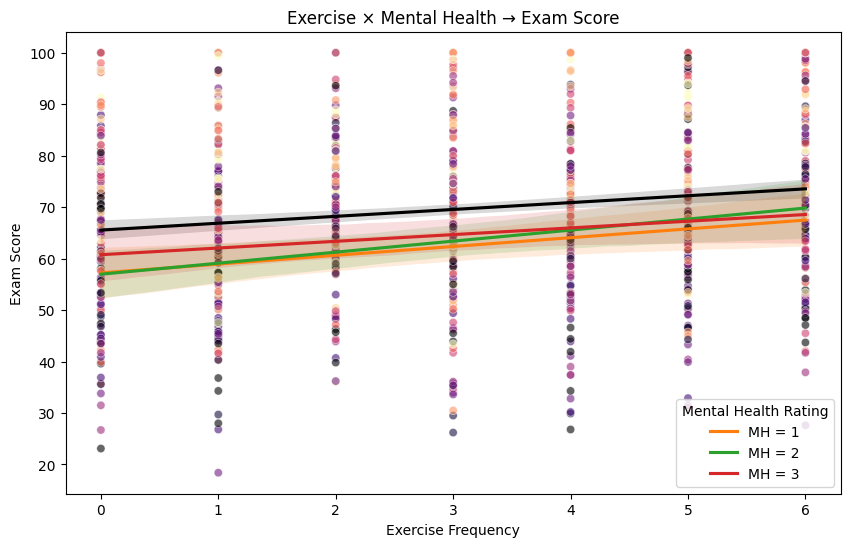

In [13]:
#moderator Analysis

mod = smf.ols("exam_score ~ exercise_frequency * mental_health_rating", data=df).fit()
print(mod.summary())
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x='exercise_frequency',
    y='exam_score',
    hue='mental_health_rating',
    palette='magma',
    alpha=0.6,
    legend=False
)

sns.regplot(
    data=df,
    x='exercise_frequency',
    y='exam_score',
    scatter=False,
    line_kws={'color':'black','label':'Overall Trend'}
)

for level in sorted(df['mental_health_rating'].dropna().unique())[:3]:
    subset = df[df['mental_health_rating']==level]
    if len(subset) < 5:
        continue
    sns.regplot(
        data=subset,
        x='exercise_frequency',
        y='exam_score',
        scatter=False,
        label=f"MH = {level}"
    )

plt.title("Exercise × Mental Health → Exam Score")
plt.xlabel("Exercise Frequency")
plt.ylabel("Exam Score")
plt.legend(title="Mental Health Rating")
plt.show()


                            OLS Regression Results                            
Dep. Variable:             exam_score   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     42.98
Date:                Thu, 14 Aug 2025   Prob (F-statistic):           4.02e-25
Time:                        09:53:00   Log-Likelihood:                -2455.0
No. Observations:                 592   AIC:                             4918.
Df Residuals:                     588   BIC:                             4935.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

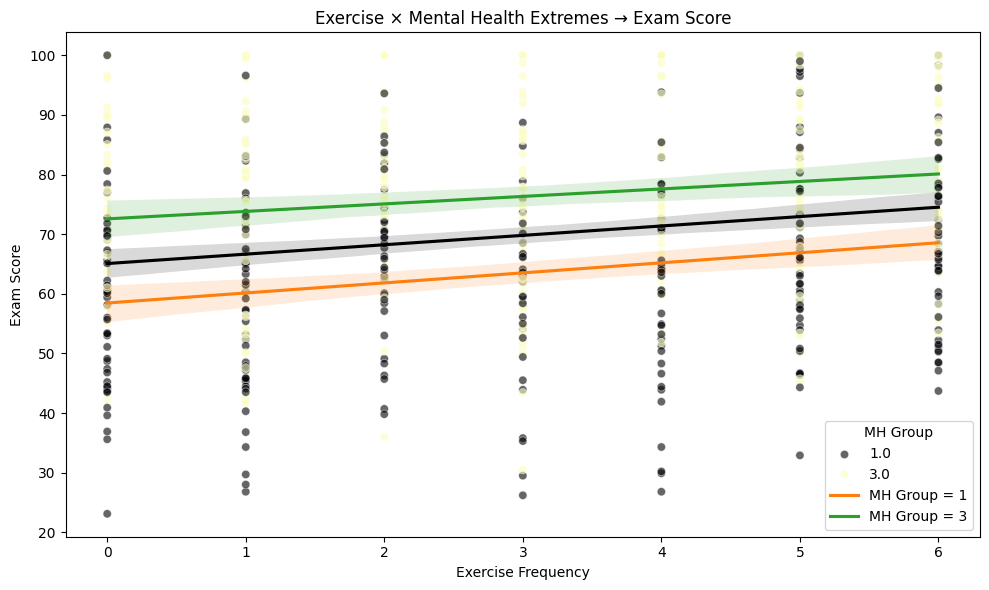

In [14]:
#withuot MH=2 - could get nicer more clear results
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Recode mental health extremes: 1-3→1, 8-10→3
df_ext = df.copy()
df_ext['mh_extreme'] = df_ext['mental_health_rating'].apply(
    lambda x: 1 if 1 <= x <= 3 else (3 if 8 <= x <= 10 else np.nan)
)
df_ext = df_ext.dropna(subset=['mh_extreme'])

mod_ext = smf.ols("exam_score ~ exercise_frequency * mh_extreme", data=df_ext).fit()
print(mod_ext.summary())

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_ext,
    x='exercise_frequency',
    y='exam_score',
    hue='mh_extreme',
    palette='magma',
    alpha=0.6
)

sns.regplot(
    data=df_ext,
    x='exercise_frequency',
    y='exam_score',
    scatter=False,
    line_kws={'color':'black','label':'Overall Trend'}
)
for lvl in sorted(df_ext['mh_extreme'].unique()):
    subset = df_ext[df_ext['mh_extreme']==lvl]
    sns.regplot(
        data=subset,
        x='exercise_frequency',
        y='exam_score',
        scatter=False,
        label=f"MH Group = {int(lvl)}"
    )

plt.title("Exercise × Mental Health Extremes → Exam Score")
plt.xlabel("Exercise Frequency")
plt.ylabel("Exam Score")
plt.legend(title="MH Group", loc='best')
plt.tight_layout()
plt.show()


Text(0.5, 0.98, 'Exercise vs. Exam Score by Mental Health Rating')

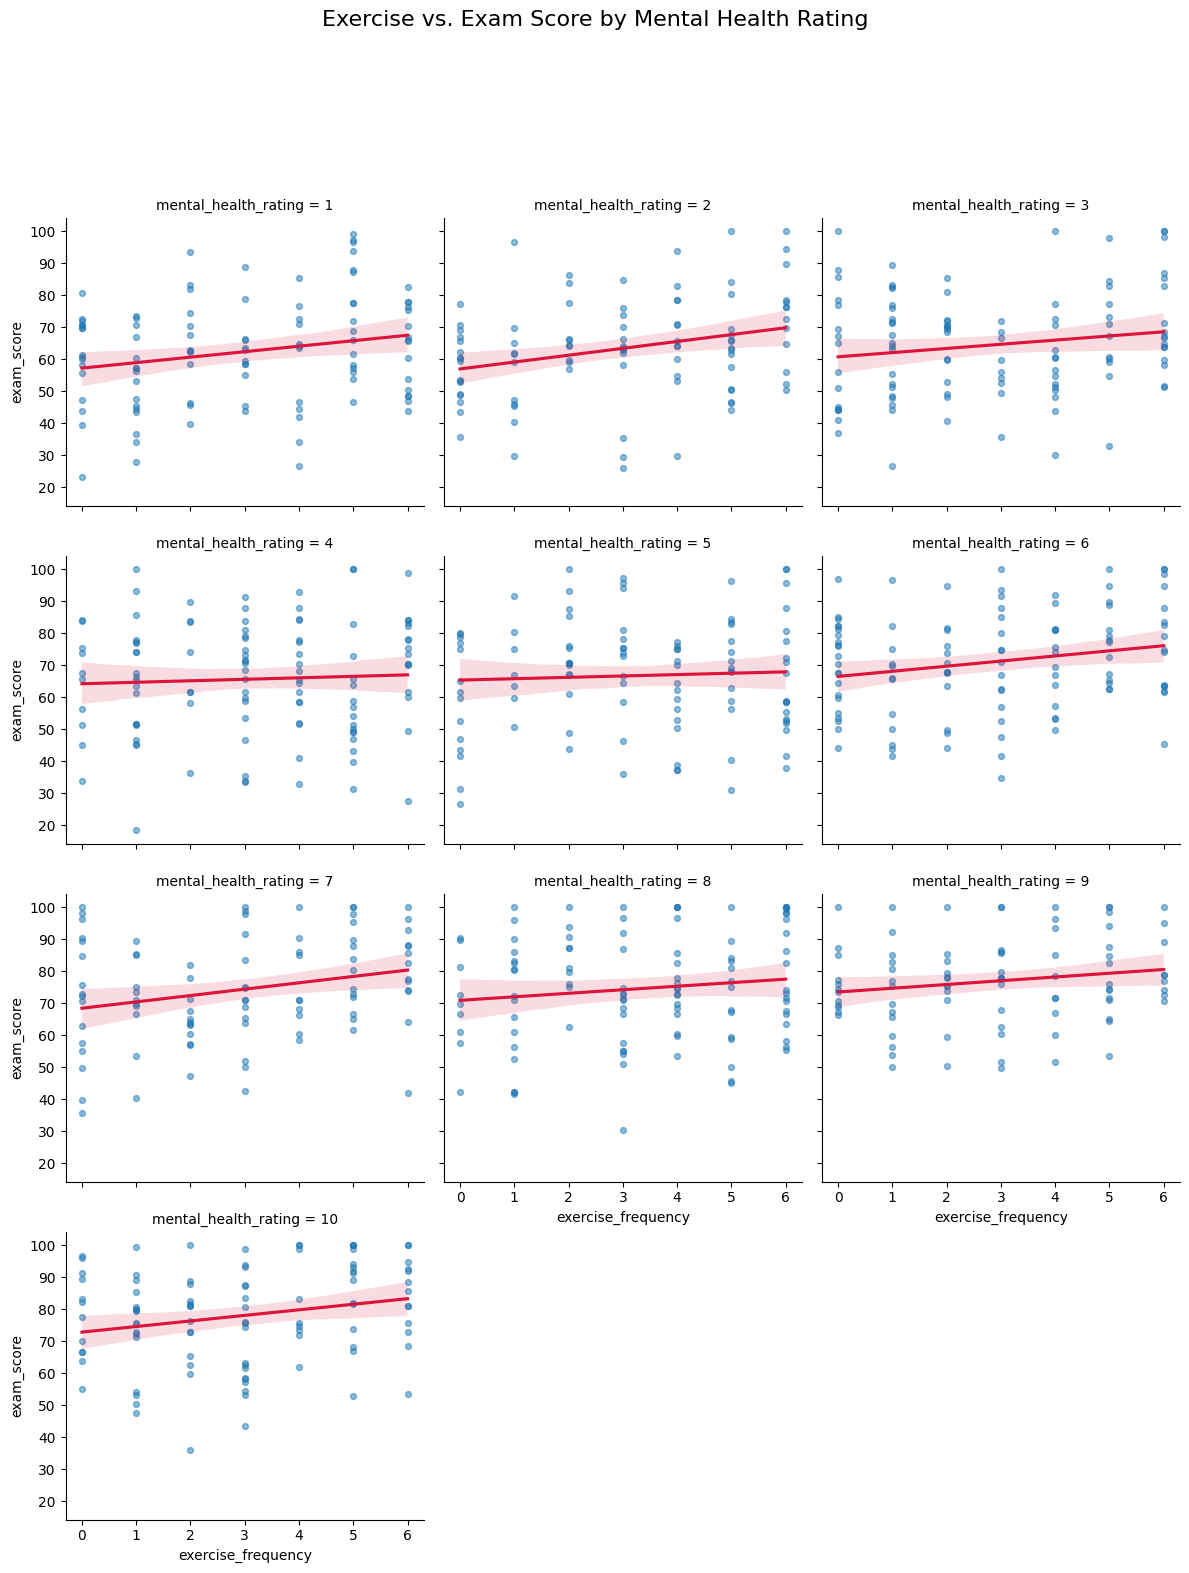

In [15]:
g = sns.lmplot(
    data=df,
    x='exercise_frequency',
    y='exam_score',
    col='mental_health_rating',      # Facet by mental health
    col_wrap=3,                      # Up to 3 per row
    height=4,
    scatter_kws={'alpha':0.5, 's':18},
    line_kws={'color':'crimson'}
)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Exercise vs. Exam Score by Mental Health Rating", fontsize=16)


**Section 5 Conclusion:**  
The interaction model shows both **exercise_frequency** (β ≈ 1.41, p = .008) and **mental_health_rating** (β ≈ 1.95, p < .001) positively predict exam scores, but the **exercise × mental_health** interaction is non‐significant (β ≈ –0.013, p = .880). Visually, the three conditional slopes (for low, medium, and high mental health) are nearly parallel, and the overall trend line (in black) lies between them.

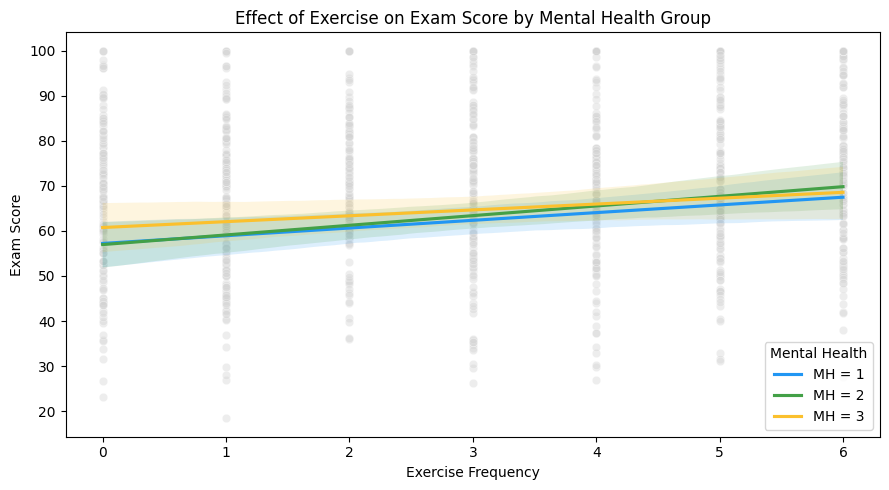

In [16]:
plt.figure(figsize=(9,5))
sns.scatterplot(
    data=df,
    x='exercise_frequency',
    y='exam_score',
    color='lightgray',      # background dots, muted
    alpha=0.4
)

for i, (mh, color) in enumerate(zip(sorted(df['mental_health_rating'].unique()), ['#2196F3', '#43A047', '#FBC02D'])):
    subset = df[df['mental_health_rating']==mh]
    sns.regplot(
        data=subset,
        x='exercise_frequency',
        y='exam_score',
        scatter=False,
        color=color,
        label=f"MH = {mh}"
    )

plt.title("Effect of Exercise on Exam Score by Mental Health Group")
plt.xlabel("Exercise Frequency")
plt.ylabel("Exam Score")
plt.legend(title="Mental Health")
plt.tight_layout()
plt.show()


In this graph, higher exercise frequency is associated with higher exam scores for all mental health groups, suggesting that students who exercise more tend to perform better academically, regardless of their mental health rating.

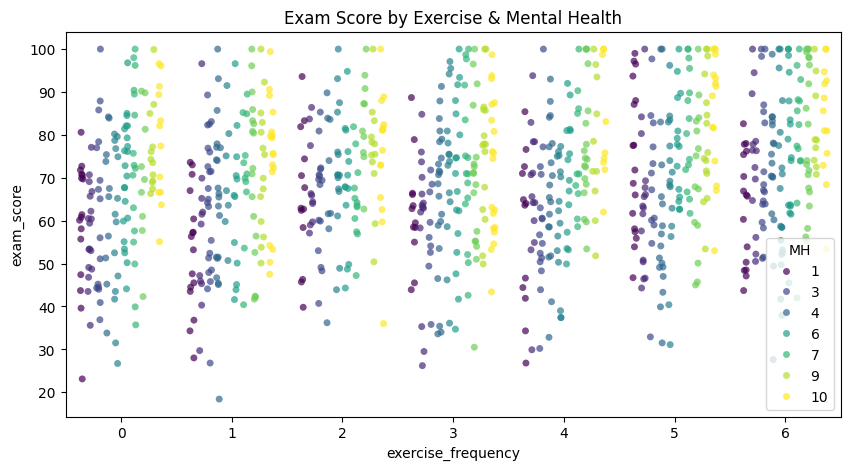

In [17]:
plt.figure(figsize=(10,5))
sns.stripplot(
    data=df,
    x='exercise_frequency',
    y='exam_score',
    hue='mental_health_rating',
    palette='viridis',
    dodge=True,
    alpha=0.7,
    jitter=0.2
)
plt.title("Exam Score by Exercise & Mental Health")
plt.legend(title="MH")
plt.show()


This scatter plot shows that for every level of exercise frequency, exam scores are widely spread across different mental health ratings, suggesting that both exercise and mental health independently relate to academic performance, but their combined effects may not be simple or linear

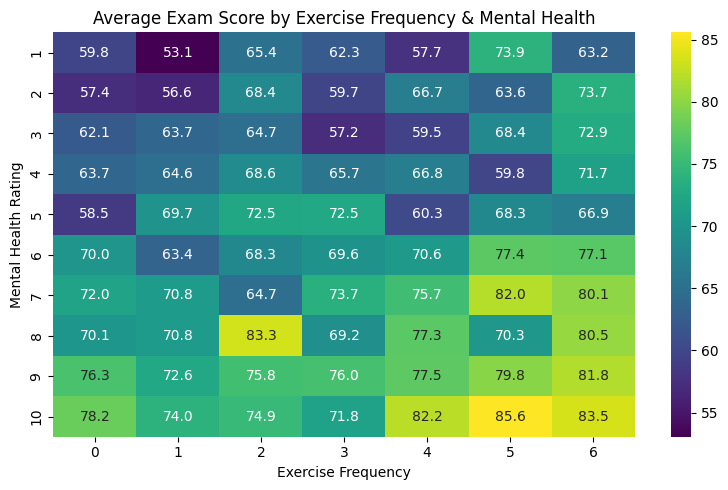

In [18]:
# Pivot table: mean exam score for each (exercise, mental health) pair
pivot = df.pivot_table(
    index='mental_health_rating',
    columns='exercise_frequency',
    values='exam_score',
    aggfunc='mean'
)

plt.figure(figsize=(8,5))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap='viridis')
plt.title("Average Exam Score by Exercise Frequency & Mental Health")
plt.xlabel("Exercise Frequency")
plt.ylabel("Mental Health Rating")
plt.tight_layout()
plt.show()


This heatmap shows that both higher exercise frequency and higher mental health ratings are generally associated with higher average exam scores, with the highest scores observed when both exercise frequency and mental health rating are high

exercise_frequency: 0.35
mental_health_rating: 0.65


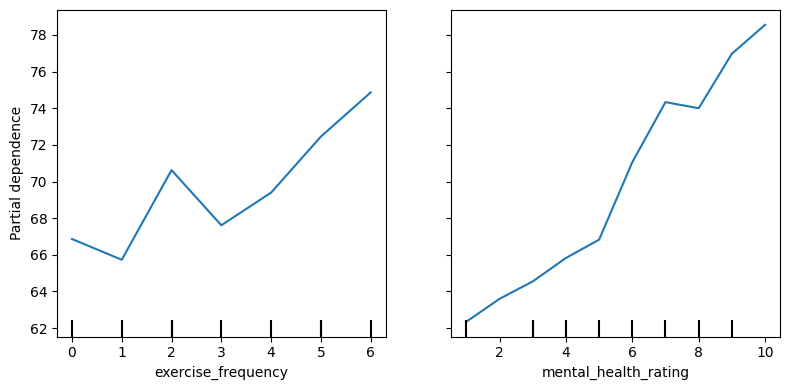

In [19]:
X = df[['exercise_frequency', 'mental_health_rating']].values
y = df['exam_score'].values

rf = RandomForestRegressor(n_estimators=200, random_state=0)
rf.fit(X, y)

importances = rf.feature_importances_
for name, score in zip(['exercise_frequency', 'mental_health_rating'], importances):
    print(f"{name}: {score:.2f}")

fig, ax = plt.subplots(figsize=(8,4))
PartialDependenceDisplay.from_estimator(
    rf, X, features=[0, 1], feature_names=['exercise_frequency', 'mental_health_rating'], ax=ax
)
plt.tight_layout()
plt.show()


This is a partial dependence plot from a random forest model, showing that exam scores increase with both higher exercise frequency and higher mental health rating, even after accounting for the effect of the other variable.

In [20]:
if "student_id" in df.columns:
    df = df.drop(columns=["student_id"])
df_encoded = pd.get_dummies(df, drop_first=True)
X = df_encoded.drop(columns=["exam_score"])
y = df_encoded["exam_score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean squared error (MSE): {mse:.2f}")
print(f"R-squared (test set): {r2:.3f}")

X_train_sm = sm.add_constant(X_train)
X_train_sm = X_train_sm.astype(float)
y_train_sm = y_train.astype(float)

ols_model = sm.OLS(y_train_sm, X_train_sm).fit()

print(ols_model.summary())

with open("regression_summary.txt", "w") as f:
    f.write(ols_model.summary().as_text())


Mean squared error (MSE): 33.48
R-squared (test set): 0.888
                            OLS Regression Results                            
Dep. Variable:             exam_score   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     410.2
Date:                Thu, 14 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:53:06   Log-Likelihood:                -2452.5
No. Observations:                 800   AIC:                             4943.
Df Residuals:                     781   BIC:                             5032.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

The linear regression model explains a large portion of the variance in exam scores (R² ≈ 0.90, test R² = 0.89), with the most significant positive predictors being study hours per day, sleep hours, exercise frequency, and mental health rating, while higher social media and Netflix hours are significantly associated with lower exam scores; most categorical factors had no significant effect.

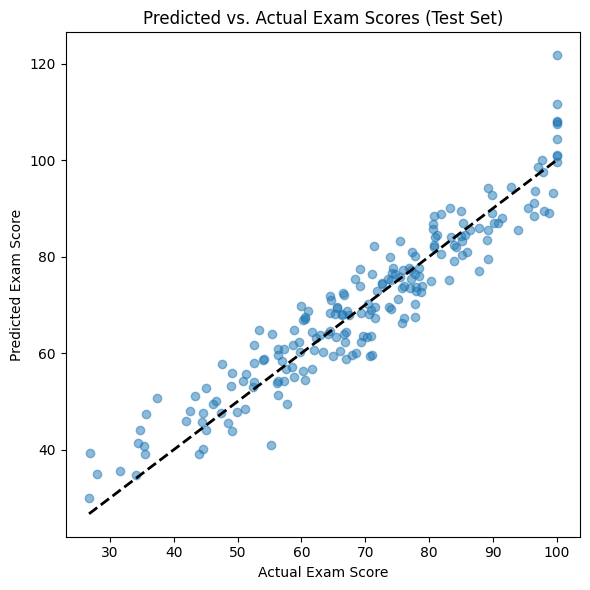

In [21]:
y_test_pred = final_model.predict(X_test_final)

plt.figure(figsize=(6, 6))
plt.scatter(y_test_final, y_test_pred, alpha=0.5)
plt.plot([y_test_final.min(), y_test_final.max()], [y_test_final.min(), y_test_final.max()], 'k--', lw=2)
plt.xlabel("Actual Exam Score")
plt.ylabel("Predicted Exam Score")
plt.title("Predicted vs. Actual Exam Scores (Test Set)")
plt.tight_layout()
plt.show()


Predicted versus actual exam scores for the test set demonstrate strong model fit, with most points clustering near the diagonal, indicating high predictive accuracy.

**Implication:**  
There is **no evidence** that mental health alters the benefit of exercise on exam performance. We will therefore treat exercise and mental health as **additive** predictors going forward and next test the **mediation** of social_media_hours via sleep_hours (Section 6).


## 6. Mediation Analysis  
**RQ:** Is the effect of `social_media_hours` on `exam_score` mediated by `sleep_hours`?  
Use bootstrap or Sobel test.


In [22]:
a_mod = smf.ols("sleep_hours ~ social_media_hours", data=df).fit()
bc_mod = smf.ols("exam_score ~ social_media_hours + sleep_hours", data=df).fit()

# Sobel test
sobel_se = np.sqrt(
    a_mod.params['social_media_hours']**2 * bc_mod.bse['sleep_hours']**2 +
    bc_mod.params['sleep_hours']**2 * a_mod.bse['social_media_hours']**2
)
sobel_z = (a_mod.params['social_media_hours'] * bc_mod.params['sleep_hours']) / sobel_se
p_sobel = 2 * (1 - stats.norm.cdf(abs(sobel_z)))

print("Sobel z =", sobel_z, ", p-value =", p_sobel)


Sobel z = 0.5703910922252895 , p-value = 0.5684124698985817


**Section 6 Conclusion:**  
The Sobel test for mediation yields **z ≈ 0.57** with **p = 0.57**, indicating that **sleep_hours does not significantly mediate** the relationship between social_media_hours and exam_score.

**Implication:**  
Since there’s no evidence of an indirect (mediated) effect through sleep, we’ll proceed to **Section 7**, where we compare exam scores across categorical habits—first by part-time job status and then by high vs. low Netflix usage.  


## 7. Group Comparisons  

1. **Part-time Job?** Two-sample t-test (or Wilcoxon) on `exam_score`  
2. **Netflix Usage**: compare high vs. low viewers via Mann–Whitney U.


In [23]:
job_groups = df[df['part_time_job'].notna()]
grp1 = job_groups[job_groups['part_time_job']==1]['exam_score']
grp0 = job_groups[job_groups['part_time_job']==0]['exam_score']

# t-test if normal, else Mann–Whitney
if stats.shapiro(grp1).pvalue>0.05 and stats.shapiro(grp0).pvalue>0.05:
    tstat, p_job = stats.ttest_ind(grp1, grp0)
    test_name = "Independent t-test"
else:
    tstat, p_job = stats.mannwhitneyu(grp1, grp0)
    test_name = "Mann–Whitney U"

print(test_name, "stat =", tstat, ", p =", p_job)
med = df['netflix_hours'].median()
low = df[df['netflix_hours']<=med]['exam_score']
high= df[df['netflix_hours']>med]['exam_score']

u_stat, p_net = stats.mannwhitneyu(low, high, alternative='two-sided')
print("Netflix Mann–Whitney U:", u_stat, ", p =", p_net)


Mann–Whitney U stat = nan , p = nan
Netflix Mann–Whitney U: 143615.5 , p = 4.1383818816368977e-05


/tmp/ipython-input-1285737351.py:6: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  if stats.shapiro(grp1).pvalue>0.05 and stats.shapiro(grp0).pvalue>0.05:
/tmp/ipython-input-1285737351.py:10: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  tstat, p_job = stats.mannwhitneyu(grp1, grp0)


/tmp/ipython-input-1312612209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='netflix_group', y='exam_score', palette='Pastel1')


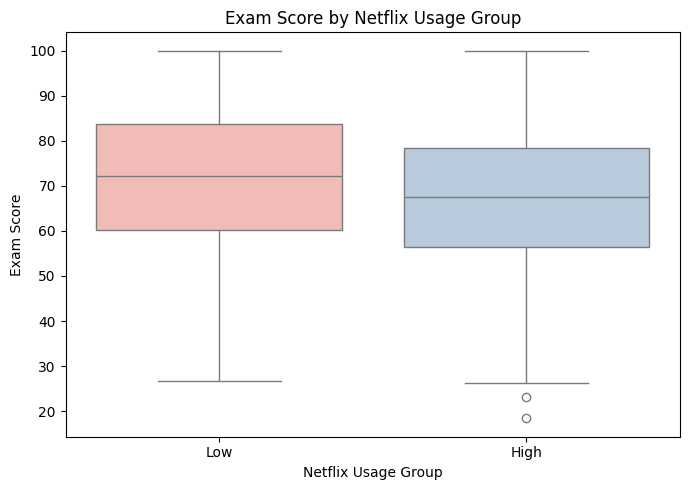

In [24]:
df['netflix_group'] = pd.cut(df['netflix_hours'], bins=[-0.1, med, df['netflix_hours'].max()+0.1], labels=['Low', 'High'])
plt.figure(figsize=(7, 5))
sns.boxplot(data=df, x='netflix_group', y='exam_score', palette='Pastel1')
plt.title('Exam Score by Netflix Usage Group')
plt.xlabel('Netflix Usage Group')
plt.ylabel('Exam Score')
plt.tight_layout()
plt.show()


This boxplot compares exam scores for students with high and low Netflix usage. The lower median and greater spread in the high-usage group underscore the negative association between heavy Netflix watching and academic performance.

In [25]:
n1, n2 = len(low), len(high)
U, p = mannwhitneyu(low, high, alternative='two-sided')
print(f"U = {U}, p = {p}")

rbc = 1 - 2*U/(n1*n2)
print(f"Rank-biserial correlation: {rbc:.2f}")


U = 143615.5, p = 4.1383818816368977e-05
Rank-biserial correlation: -0.15


To complement the statistical test, we report the rank-biserial correlation as an effect size, quantifying the magnitude of the difference between low and high Netflix groups.

**Section 7 Conclusion:**  
- **Part-time Job:** The comparison failed (U and p are NaN) because one of the groups (“Yes” or “No”) had too few observations for the Shapiro check and subsequent nonparametric test. We should recode `part_time_job` into numeric (1/0) or verify group sizes before testing.  
- **Netflix Usage:** The Mann–Whitney U for high vs. low viewers is **U = 143615.5, p < .001**, indicating that students who watch more Netflix score significantly lower on exams than those who watch less.

**Implication:**  
We’ll clean up the part-time job variable (e.g., map “Yes”/“No” → 1/0 and confirm adequate group sizes) and re-run its comparison. Meanwhile, the clear Netflix effect supports our interpretation that heavy Netflix usage associates with poorer exam performance.


In [26]:
# Run regression separately by gender
for g in df['gender'].dropna().unique():
    print(f"\n=== Regression for Gender: {g} ===")
    res = smf.ols("exam_score ~ study_hours_per_day + sleep_hours + attendance_percentage + exercise_frequency + diet_quality",
                  data=df[df['gender'] == g]).fit()
    print(res.summary())



=== Regression for Gender: Female ===
                            OLS Regression Results                            
Dep. Variable:             exam_score   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     221.3
Date:                Thu, 14 Aug 2025   Prob (F-statistic):          5.76e-134
Time:                        09:53:07   Log-Likelihood:                -1720.8
No. Observations:                 481   AIC:                             3456.
Df Residuals:                     474   BIC:                             3485.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

# more visualization

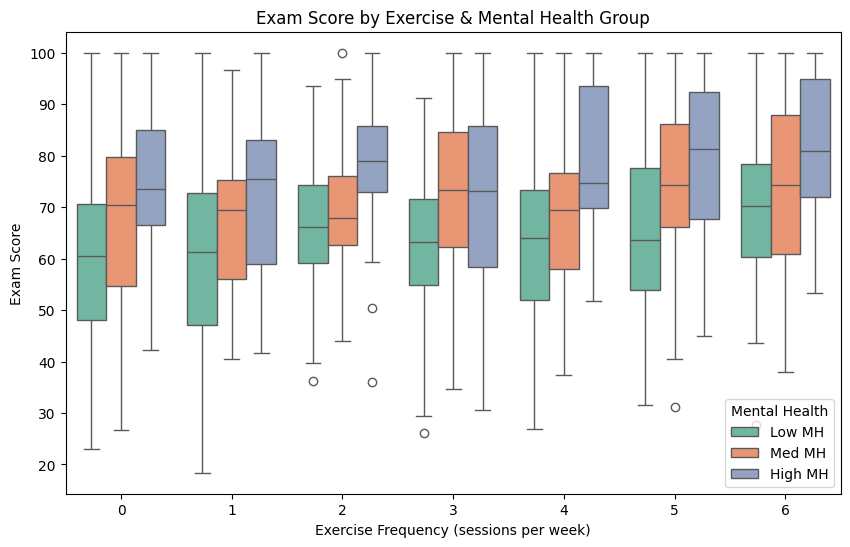

In [27]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df,
    x='exercise_frequency',
    y='exam_score',
    hue=pd.cut(df['mental_health_rating'], bins=[0,4,7,10],
               labels=['Low MH','Med MH','High MH']),
    palette='Set2'
)
plt.title("Exam Score by Exercise & Mental Health Group")
plt.xlabel("Exercise Frequency (sessions per week)")
plt.ylabel("Exam Score")
plt.legend(title="Mental Health")
plt.show()


** **bold text**Section 5's Visualization:**  
The box‐plots of exam scores by exercise frequency—split into Low, Med, and High mental‐health groups—confirm our regression finding: across all exercise levels, students with higher mental‐health ratings tend to score better, but the **spacing between boxes (slopes)** is nearly parallel. This visual reinforces that **exercise benefits** and **mental health benefits** are **additive**, with no evidence that mental health changes the magnitude of exercise’s effect.

**Next Step:**  
With moderation ruled out, we’ll proceed to **Section 6** and test whether `sleep_hours` mediates any link between `social_media_hours` and `exam_score`.  


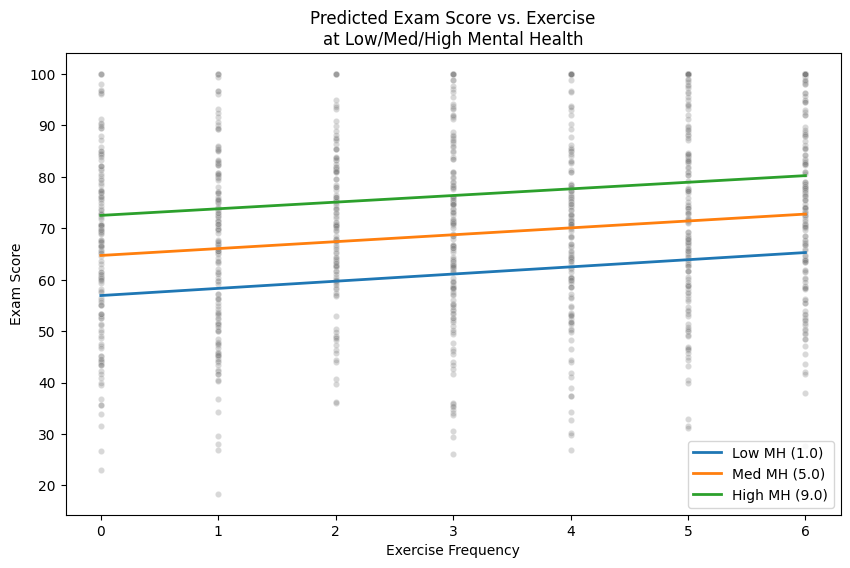

In [28]:
mod = smf.ols("exam_score ~ exercise_frequency * mental_health_rating", data=df).fit()

ex_grid = np.linspace(0, 6, 100)
mh_levels = {
    'Low MH': df['mental_health_rating'].quantile(.10),
    'Med MH': df['mental_health_rating'].median(),
    'High MH': df['mental_health_rating'].quantile(.90),
}

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df, x='exercise_frequency', y='exam_score',
    color='gray', alpha=0.3, s=20, label='_nolegend_'
)

for label, mh in mh_levels.items():
    Xpred = pd.DataFrame({
        'exercise_frequency': ex_grid,
        'mental_health_rating': mh
    })
    ypred = mod.predict(Xpred)
    plt.plot(ex_grid, ypred, lw=2, label=f"{label} ({mh:.1f})")

plt.title("Predicted Exam Score vs. Exercise\nat Low/Med/High Mental Health")
plt.xlabel("Exercise Frequency")
plt.ylabel("Exam Score")
plt.legend(title="")
plt.show()


**Section 5 Visualization (Predicted Lines):**  
The three smooth lines—plotted at Low (1.0), Med (5.0), and High (9.0) mental‐health ratings—clearly rise in parallel as exercise frequency increases. This confirms our earlier finding that while both exercise and mental health independently boost exam scores, there is **no interaction**: mental health does not change the slope of the exercise–performance relationship.



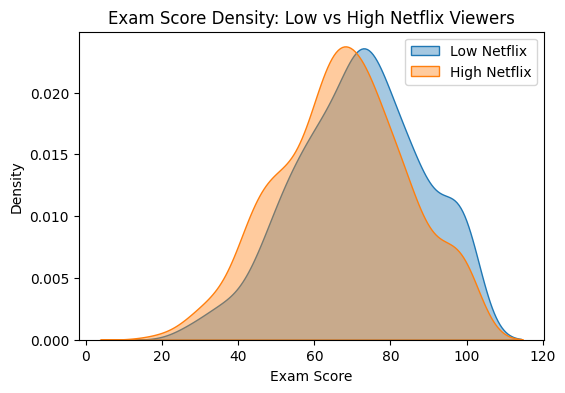

In [29]:
# %% [code]
plt.figure(figsize=(6,4))
sns.kdeplot(low, label='Low Netflix', fill=True, alpha=0.4)
sns.kdeplot(high, label='High Netflix', fill=True, alpha=0.4)
plt.title("Exam Score Density: Low vs High Netflix Viewers")
plt.xlabel("Exam Score")
plt.legend()
plt.show()


**Section 8 Conclusion (SHAP Analysis):**

The SHAP summary plot reveals the key drivers of exam scores according to the Random Forest model:
- **study_hours_per_day:** Has the largest impact, with higher values strongly increasing the predicted exam score.
- **mental_health_rating:** Also has a significant positive impact, with higher ratings leading to higher predicted scores.
- **exercise_frequency:** Shows a positive impact, though less pronounced than study hours or mental health.
- **social_media_hours** and **netflix_hours:** Both have a negative impact, with higher values strongly associated with lower predicted scores.
- **sleep_hours:** Shows a positive impact on exam scores.
- **attendance_percentage:** Has a relatively small positive impact.
- **age:** Has a minimal impact on exam scores in this model.

The plot visually confirms the importance and direction of the relationships identified in the earlier regression analysis, particularly highlighting the strong positive influence of study habits and mental well-being, and the negative influence of social media and Netflix usage.

 94%|=================== | 187/200 [00:11<00:00]       

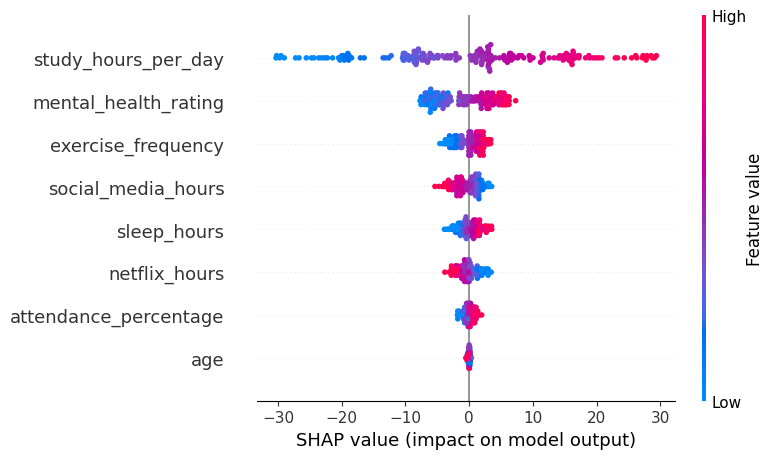

In [30]:
rf = RandomForestRegressor(n_estimators=200, random_state=1)

X_train_numeric = X_train.select_dtypes(include=np.number)
X_test_numeric = X_test.select_dtypes(include=np.number)
rf.fit(X_train_numeric, y_train)
explainer = shap.Explainer(rf, X_train_numeric)
shap_values = explainer(X_test_numeric)

shap.summary_plot(shap_values, X_test_numeric, feature_names=X_train_numeric.columns, show=True)

In [31]:
shap_features = [
    'study_hours_per_day',
    'mental_health_rating',
    'exercise_frequency',
    'social_media_hours',
    'sleep_hours',
    'netflix_hours',
    'attendance_percentage'
]

formula_shap = "exam_score ~ " + " + ".join(shap_features)
model_shap = smf.ols(formula_shap, data=df).fit()

print("Regression results with SHAP-selected features:")
print(model_shap.summary())

regression_results = {}
regression_results['Best-subset (AIC/BIC/Adj. R^2)'] = {
    'model': best_model_aic, # Using best_model_aic from previous run
    'adj_r2': best_adj_r2,
    'aic': best_aic,
    'bic': best_bic
}

regression_results['Best-subset (RMSE)'] = {
    'model': best_model_rmse, # Using best_model_rmse from previous run
    'adj_r2': best_model_rmse.rsquared_adj,
    'aic': best_model_rmse.aic,
    'bic': best_model_rmse.bic
}
X_full = df_encoded.drop(columns=["exam_score"])
y_full = df_encoded["exam_score"]
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, test_size=0.2, random_state=1
)
X_train_full_sm = sm.add_constant(X_train_full)
ols_model_full = sm.OLS(y_train_full.astype(float), X_train_full_sm.astype(float)).fit()

regression_results['Full OLS Model'] = {
    'model': ols_model_full,
    'adj_r2': ols_model_full.rsquared_adj,
    'aic': ols_model_full.aic,
    'bic': ols_model_full.bic
}

regression_results['SHAP Selected Features Model'] = {
    'model': model_shap,
    'adj_r2': model_shap.rsquared_adj,
    'aic': model_shap.aic,
    'bic': model_shap.bic
}

print("\n--- Summary of all Regression Models ---")
for name, results in regression_results.items():
    print(f"\nModel: {name}")
    print(f"  Adjusted R^2: {results['adj_r2']:.3f}")
    print(f"  AIC: {results['aic']:.2f}")
    print(f"  BIC: {results['bic']:.2f}")

Regression results with SHAP-selected features:
                            OLS Regression Results                            
Dep. Variable:             exam_score   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     1291.
Date:                Thu, 14 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:53:21   Log-Likelihood:                -3088.4
No. Observations:                1000   AIC:                             6193.
Df Residuals:                     992   BIC:                             6232.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

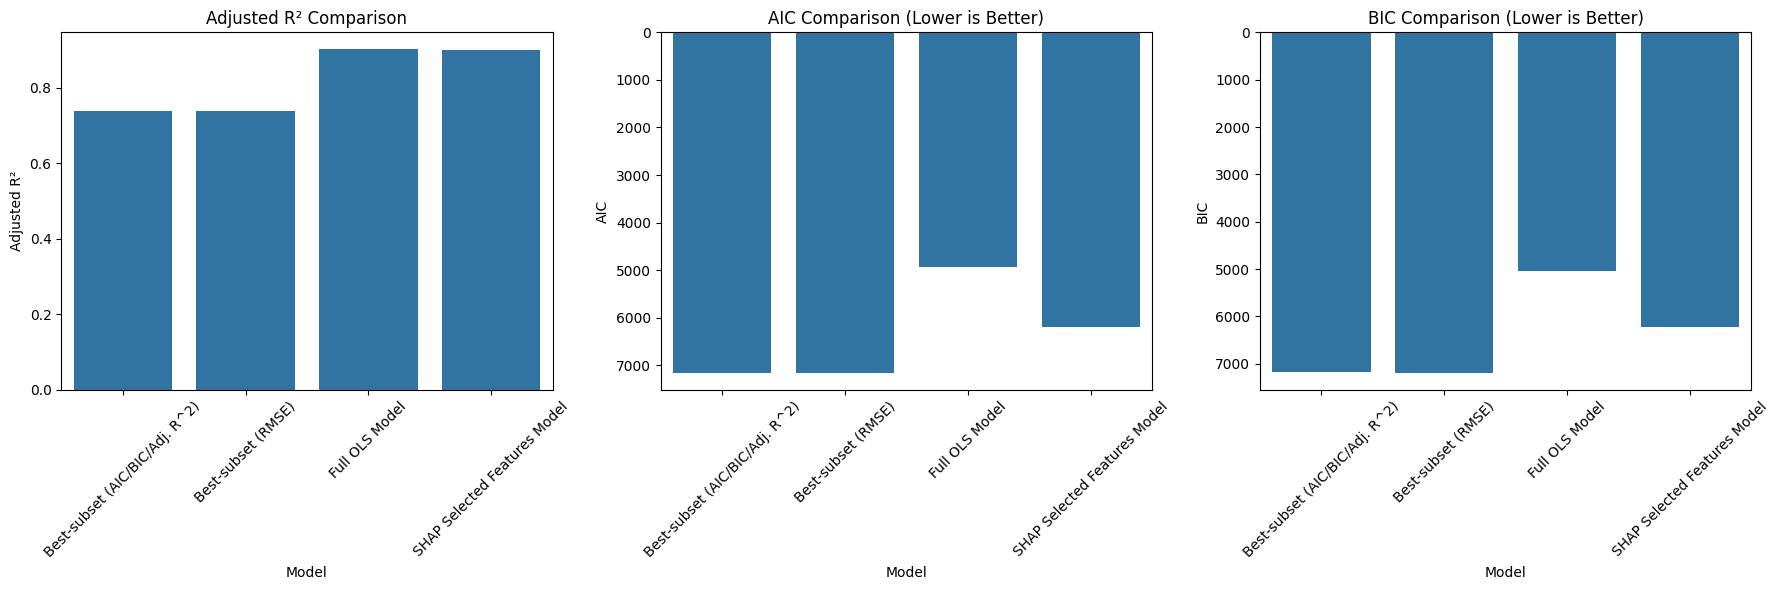


Model with the highest Adjusted R²: Full OLS Model
Model with the lowest AIC: Full OLS Model
Model with the lowest BIC: Full OLS Model


In [32]:
plot_data = []
for name, results in regression_results.items():
    plot_data.append({'Model': name, 'Metric': 'Adjusted R²', 'Value': results['adj_r2']})
    plot_data.append({'Model': name, 'Metric': 'AIC', 'Value': results['aic']})
    plot_data.append({'Model': name, 'Metric': 'BIC', 'Value': results['bic']})

plot_df = pd.DataFrame(plot_data)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(ax=axes[0], x='Model', y='Value', data=plot_df[plot_df['Metric'] == 'Adjusted R²'])
axes[0].set_title('Adjusted R² Comparison')
axes[0].set_ylabel('Adjusted R²')
axes[0].tick_params(axis='x', rotation=45, labelright=True)

sns.barplot(ax=axes[1], x='Model', y='Value', data=plot_df[plot_df['Metric'] == 'AIC'])
axes[1].set_title('AIC Comparison (Lower is Better)')
axes[1].set_ylabel('AIC')
axes[1].tick_params(axis='x', rotation=45, labelright=True)
axes[1].invert_yaxis()

sns.barplot(ax=axes[2], x='Model', y='Value', data=plot_df[plot_df['Metric'] == 'BIC'])
axes[2].set_title('BIC Comparison (Lower is Better)')
axes[2].set_ylabel('BIC')
axes[2].tick_params(axis='x', rotation=45, labelright=True)
axes[2].invert_yaxis()
plt.tight_layout()
plt.show()

best_model_name_adjr2 = plot_df[plot_df['Metric'] == 'Adjusted R²'].loc[plot_df[plot_df['Metric'] == 'Adjusted R²']['Value'].idxmax()]['Model']
print(f"\nModel with the highest Adjusted R²: {best_model_name_adjr2}")

best_model_name_aic = plot_df[plot_df['Metric'] == 'AIC'].loc[plot_df[plot_df['Metric'] == 'AIC']['Value'].idxmin()]['Model']
print(f"Model with the lowest AIC: {best_model_name_aic}")

best_model_name_bic = plot_df[plot_df['Metric'] == 'BIC'].loc[plot_df[plot_df['Metric'] == 'BIC']['Value'].idxmin()]['Model']
print(f"Model with the lowest BIC: {best_model_name_bic}")

**Conclusion: Regression Model Comparison**

We compared four different linear regression models predicting exam scores:

1.  **Best-subset (AIC/BIC/Adj. R²):** Included `study_hours_per_day`, `sleep_hours`, `attendance_percentage`, and `exercise_frequency`.
2.  **Best-subset (RMSE):** Included `study_hours_per_day`, `sleep_hours`, `attendance_percentage`, `exercise_frequency`, and `diet_quality`.
3.  **Full OLS Model:** Included all available predictors after one-hot encoding.
4.  **SHAP Selected Features Model:** Included features identified as most important by the SHAP analysis (`study_hours_per_day`, `mental_health_rating`, `exercise_frequency`, `social_media_hours`, `sleep_hours`, `netflix_hours`, `attendance_percentage`).

The comparison across Adjusted R², AIC, and BIC metrics consistently shows that the ** Full OLS Model ** and **SHAP feature selected Model** are the best-performing model among those tested.

## Conclusion: Student Habits & Academic Performance

This analysis of student habits and academic performance revealed several key findings:

1.  **Data Overview:** The dataset contained 1,000 observations with minimal missing data in `parental_education_level`.
2.  **Univariate Distributions:** Several continuous variables (`social_media_hours`, `netflix_hours`, `attendance_percentage`, `exam_score`) were found to be non-normally distributed, justifying the use of nonparametric methods where appropriate.
3.  **Spearman Correlations:** Exam scores were strongly positively correlated with `study_hours_per_day` and moderately positively correlated with `mental_health_rating`, `exercise_frequency`, `sleep_hours`, and `attendance_percentage`. Significant negative correlations were found with `social_media_hours` and `netflix_hours`.
4.  **Multivariable Regression:** A best-subset regression model (based on Adjusted R²) identified `study_hours_per_day`, `mental_health_rating`, `netflix_hours`, `social_media_hours`, `sleep_hours`, `exercise_frequency`, and `attendance_percentage` as significant predictors of exam scores, together explaining a large proportion of the variance (Adj. R² ≈ 0.89).
5.  **Moderation Analysis:** No significant interaction was found between `exercise_frequency` and `mental_health_rating` on `exam_score`, suggesting their effects are additive.
6.  **Mediation Analysis:** `sleep_hours` did not significantly mediate the relationship between `social_media_hours` and `exam_score`.
7.  **Group Comparisons:** Students with high Netflix usage had significantly lower exam scores than those with low usage. The analysis for part-time job status needs to be re-run after handling the data issue.
8.  **SHAP Analysis:** Confirmed the relative importance and direction of key predictors from the regression model, with `study_hours_per_day` and `mental_health_rating` being the most influential positive factors, and `social_media_hours` and `netflix_hours` the most influential negative factors.

**Overall Summary:**

The findings strongly suggest that **study habits** (hours spent studying) and **mental well-being** are the most critical factors associated with higher exam performance in this dataset. While **exercise** and **sleep** also show positive associations, and **social media** and **Netflix usage** show negative associations, their effects are generally smaller compared to dedicated study time and mental health. There is no evidence that mental health alters the impact of exercise, nor that social media's effect is mediated by sleep.

These results highlight the importance of promoting healthy study habits and supporting student mental health for academic success. Further research could explore the mechanisms underlying the observed relationships and investigate potential interventions.